# Optimal feature clustering - Part II
> Feature clustering finds several applications in finance: portfolio construction, feature selection, regime detection, etc. In part I of this series,

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy, Feature Selection, Variation of Information, Correlation Distance]
- image: images/post_image_optimal_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

## Introduction

## Distance metrics for feature comparison

Now that we have a generic framework for optimal clustering, we can go back to the particular problem of feature clustering. We need an appropriate way to compare 2 feautures or, to put it differently, we need to be able to calculate the distance between feature (or variable) $X$ and $Y$.

Let me discuss some possible metrics {% cite Prado2020 %}:

**1. Correlation distance (two-sided)**: $ d_\rho (X, Y) = \sqrt{(1-\rho(X,Y))/2} $

Here, $\rho(X,Y)$ is the correlation coefficient between $X$ and $Y$. This definition has the property that, if $X$ and $Y$ are perfectly anti-correlated the distance between them is maximal. On the other hand, if $\rho(X,Y) = 1 \implies d_\rho = 0$.

**2. Correlation distance (one-sided)**: $ d_{\vert \rho \vert} = \sqrt{1 - \vert \rho(X,Y) \vert} $

Depending on the application, we may want the property of zero distance for both perfect correlation and anti-correlation. This alternative definition satisfy exactly that, besides setting a maximum distance between $X$ and $Y$ when they are completely uncorrelated.

**3. Variation of information**: $d_I(X,Y) = 1 - \frac{I(X,Y)}{S(X,Y}$

Both correlation-based metrics above share the same limitation. They are well well defined if the relationship between $X$ and $Y$ is linear or, equivalently, if they follow a bivariate normal distribution. I have discussed in a previous [post](https://joaodmrodrigues.github.io/elements-financial-machine-learning/information%20theory/mutual%20information/feature%20selection/feature%20importance/2021/02/06/mutal_information_and_feature_selection.html) how information-theoretic quantities allows us to measure a broader class of relations. In this context, we can define above entropy-based distance metric called *variation of information*. Here, $S(X,Y)$ and $I(X,Y)$ are the joint entropy and mutual information between $X$ and $Y$, respectively. In this framework, the distance between $X$ and $Y$ vanishes if and only if they are independent. Check out my previous post for a discussion and proper definition of entropy and mutual information. I will skip this step here.

All three quantities defined above are true metrics, in the sense that they satisfy all the properties required by a metric: non-negativity, symmetry and triangle inequality. They then allow the construction of a topological structure in this space of features. Besides, all three metrics are normalized, such that $0 \leq d \leq 1$.

**1. Correlation distance (two-sided):**

In [13]:
def calculate_corr_distance_2side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt((1-rho)/2)
    return distance

**2. Correlation distance (one-sided):**

In [14]:
def calculate_corr_distance_1side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt(1-np.abs(rho))
    return distance

**3. Variation of information:**

In [15]:
#collapse-show
def calculate_entropy(X):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram(X, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_joint_entropy(X, Y):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram2d(X, Y, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_mutual_information(X, Y):
    S_X = calculate_entropy(X)
    S_Y = calculate_entropy(Y)
    S_XY = calculate_joint_entropy(X, Y)
    I = S_X+S_Y-S_XY
    return I

def calculate_variation_of_information(X, Y):
    I = calculate_mutual_information(X, Y)
    S = calculate_joint_entropy(X, Y)
    distance = 1 - I/S
    
    return distance

**Numerical illustration:**

In [16]:
#collapse-show
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

def generate_correlated_samples(N, rho):
    # The desired covariance matrix.
    r = np.array([[1.0, rho],
                 [rho, 1.0]])
    # Generate samples from 2 independent normally distributed N(0,1)
    x = norm.rvs(size=(2, N))
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    
    return (y[0,:], y[1,:])

In [17]:
rhos = [0, 0.5, -0.9]
samples = [generate_correlated_samples(N=1000, rho=rho) for rho in rhos]

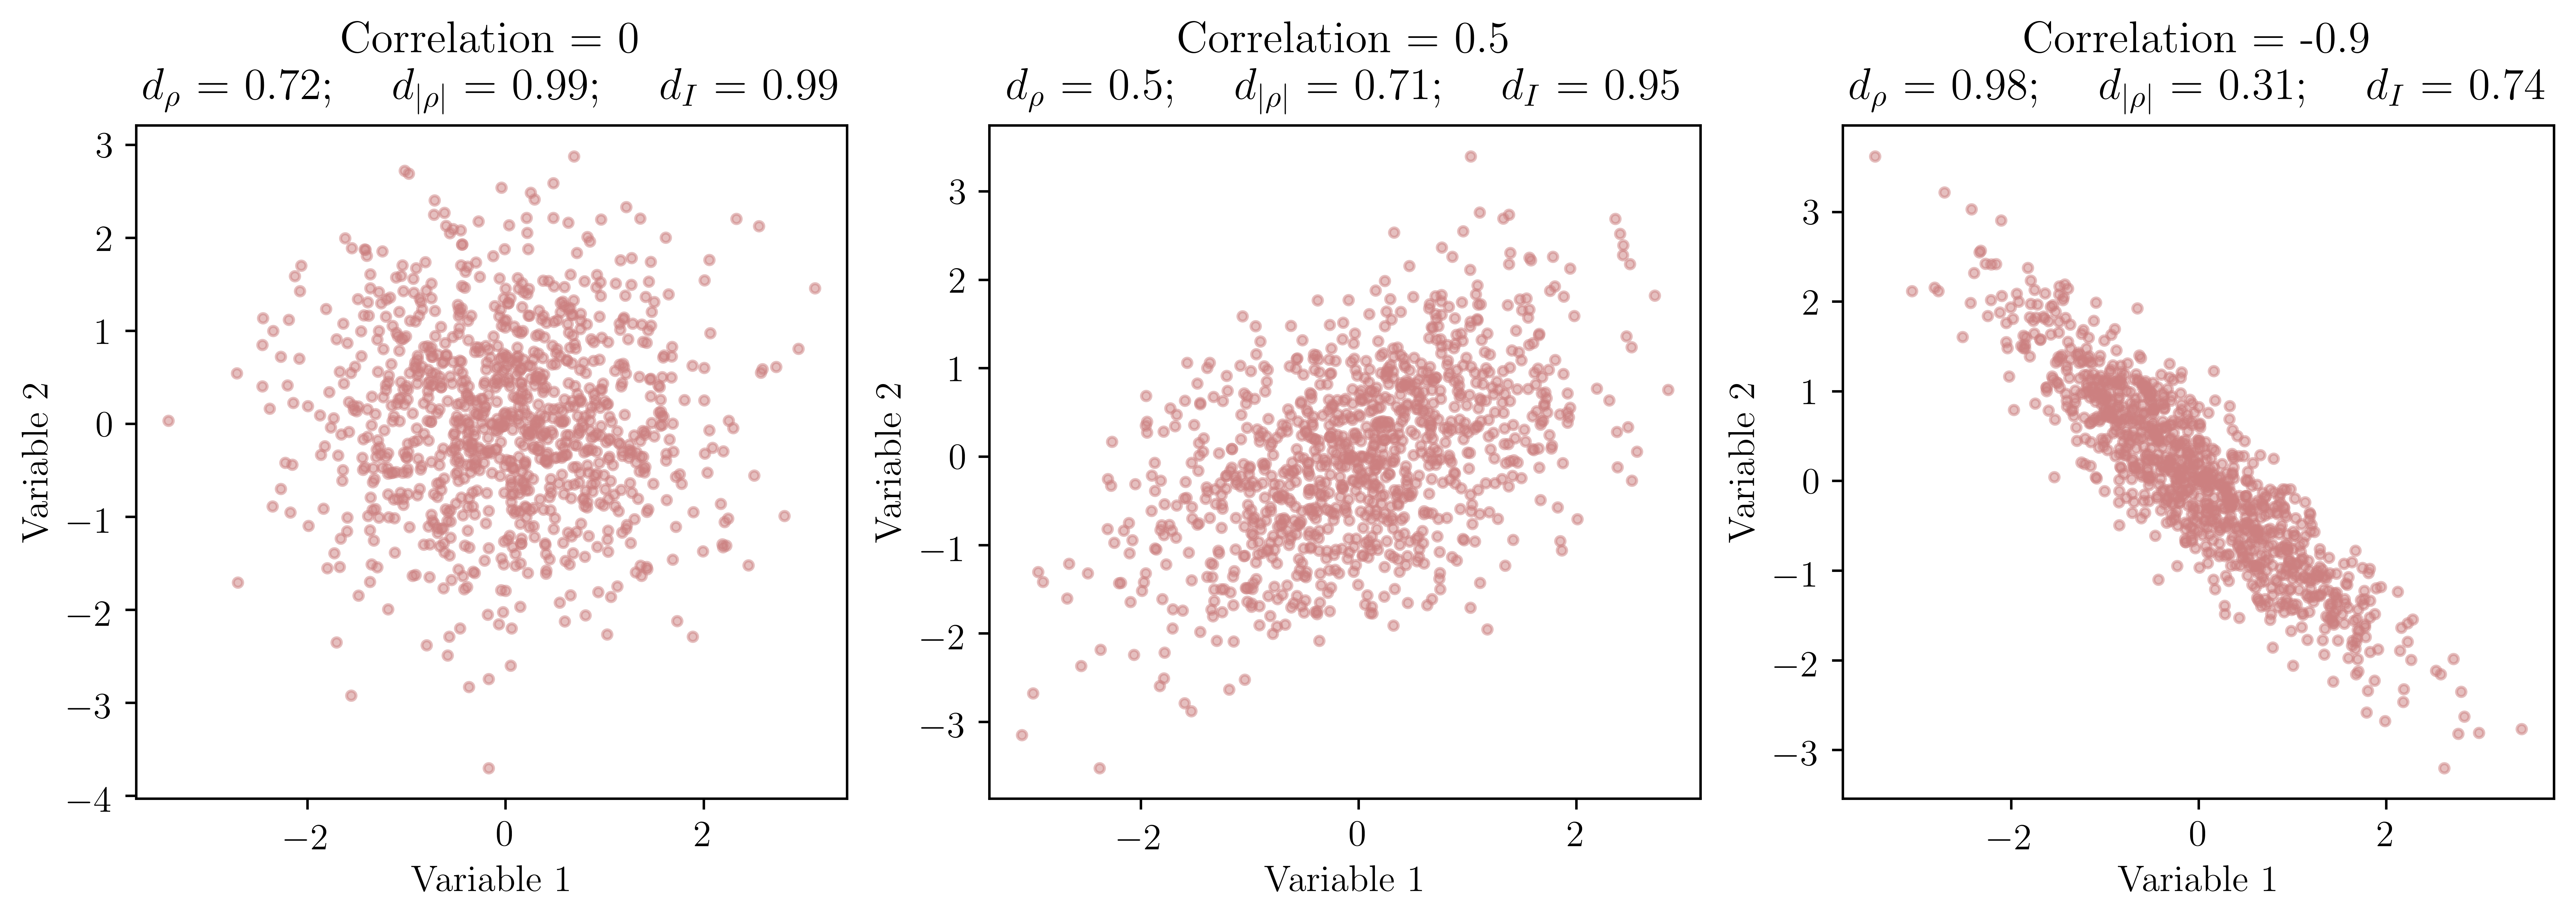

In [19]:
#collapse-hide
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, rho in enumerate(rhos):
    axes[i].plot(samples[i][0], samples[i][1], '.', color=(0.8,0.5,0.5,0.5))
    axes[i].set_xlabel("Variable 1")
    axes[i].set_ylabel("Variable 2")
    axes[i].set_title("Correlation = "+str(rho)+
                      "\n$d_\\rho$ = "+str(np.round(calculate_corr_distance_2side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_{\\vert \\rho \\vert}$ = "+str(np.round(calculate_corr_distance_1side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_I$ = "+str(np.round(calculate_variation_of_information(samples[i][0], samples[i][1]),2)))
plt.tight_layout()
plt.show()

Now a nonlinear relationship

In [58]:
X = norm.rvs(size=(1, 1000))[0,:]
noise = [0.1, 1.0, 2.0]
samples = [(X, X**2 + value*norm.rvs(size=(1, 1000))[0,:]) for value in noise]

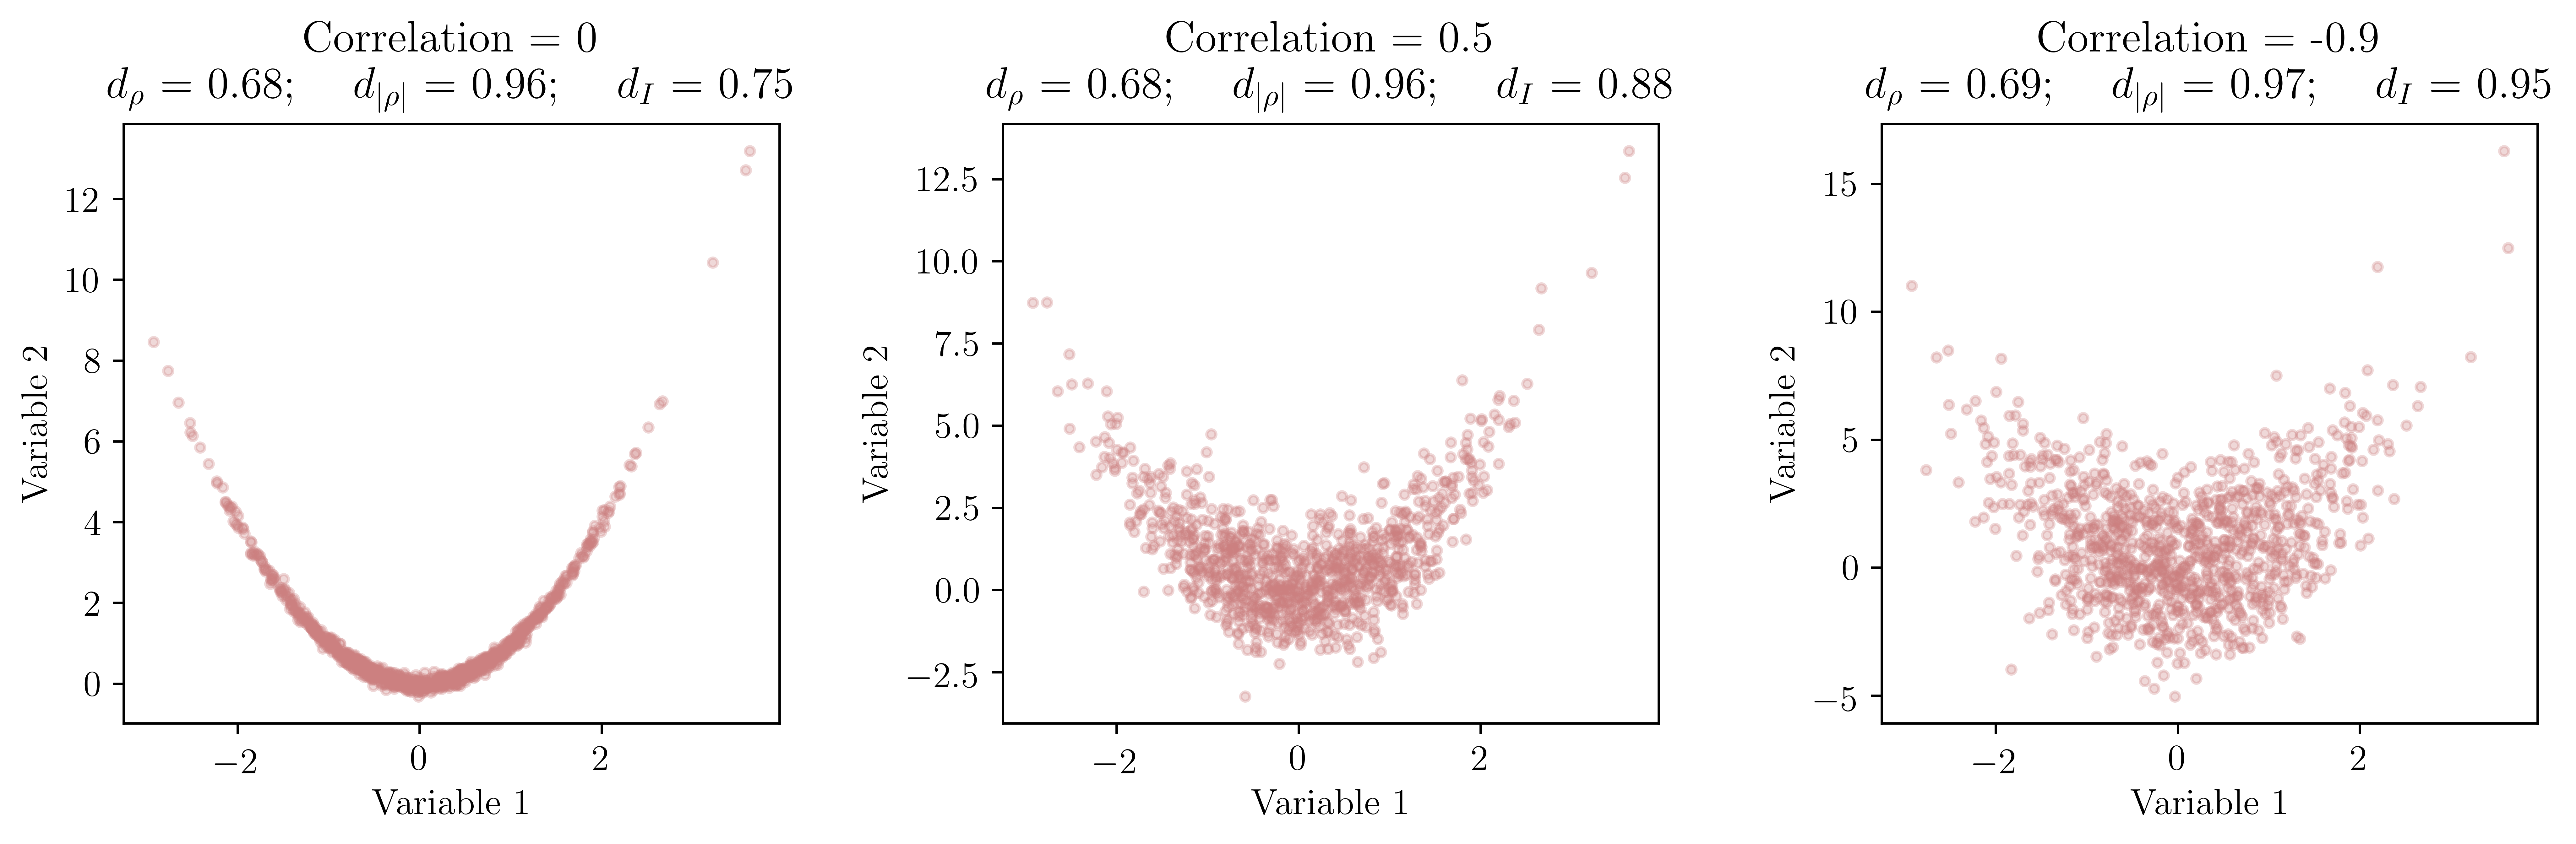

In [59]:
#hide_input
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, rho in enumerate(rhos):
    axes[i].plot(samples[i][0], samples[i][1], '.', color=(0.8,0.5,0.5,0.3))
    axes[i].set_xlabel("Variable 1")
    axes[i].set_ylabel("Variable 2")
    axes[i].set_title("Correlation = "+str(rho)+
                      "\n$d_\\rho$ = "+str(np.round(calculate_corr_distance_2side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_{\\vert \\rho \\vert}$ = "+str(np.round(calculate_corr_distance_1side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_I$ = "+str(np.round(calculate_variation_of_information(samples[i][0], samples[i][1]),2)))
plt.tight_layout()
plt.show()

Note that, variation of information is still relative high, partially because of the degeneracy in the variables. Knowing Y does not determine X even with zero noise

now describe how to join these metrics with the clustering framework described before.

**References:**

{% bibliography --cited %}